The following is a personal project based on my senior thesis work, looking at how Kazakhstan's relationships changed post-Russian invasion of Ukraine. This project utilizes web scraping for data analysis.

In [45]:
#import packages
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import time
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


Headlines from the official website of the Kazakh Embassy are scraped to track Kazakhstan’s diplomatic activity and international engagement. By extracting and analyzing the text of these news updates, it is possible to identify mentions of foreign countries or nationalities that appear in the context of meetings, visits, or official statements. This provides a way to record which countries are engaging with Kazakhstan over time, offering insight into the country’s evolving diplomatic relationships post-invasion of Ukraine.

In [ ]:
driver = webdriver.Chrome()

url = "https://www.gov.kz/memleket/entities/mfa/press/news/1?lang=en"
driver.get(url)

titles = []
dates = []

# Start the timer
start_time = time.time()
timeout_duration = 20 * 60  # 20 minutes

while True:
    # Check if we've hit the timeout
    if time.time() - start_time > timeout_duration:
        print("Timeout reached. Exiting loop.")
        break

    try:
        # Wait for the main container of news items to load
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div.card-news-list__item'))
        )
        
        # Parse current page source with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        # Extract titles
        title_divs = soup.find_all('div', class_='inner-html')
        titles_text = [t.get_text(strip=True) for t in title_divs]
        
        # Extract dates
        date_ps = soup.find_all('p', class_='typography typography__variant-caption categories__item color_grey')
        dates_text = [d.get_text(strip=True) for d in date_ps]
        
        # Append to lists
        titles.extend(titles_text)
        dates.extend(dates_text)
        
        # Find and click the "Next page" button
        next_button = driver.find_element(By.CSS_SELECTOR, 'button[aria-label="Next page"]')
        
        if not next_button.is_enabled():
            print("Next button is disabled. Ending pagination.")
            break
        
        driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
        time.sleep(1)
        driver.execute_script("arguments[0].click();", next_button)

        # Wait for page to load
        time.sleep(2)
        
    except (TimeoutException, NoSuchElementException) as e:
        print(f"Error or no more pages: {e}")
        break

driver.quit()

# Build df
df = pd.DataFrame({'date': dates, 'title': titles})
df.to_csv('headings_and_dates.csv')

In [4]:
df=pd.read_csv("headings_and_dates.csv")
df=df.drop_duplicates(["date", "title"])

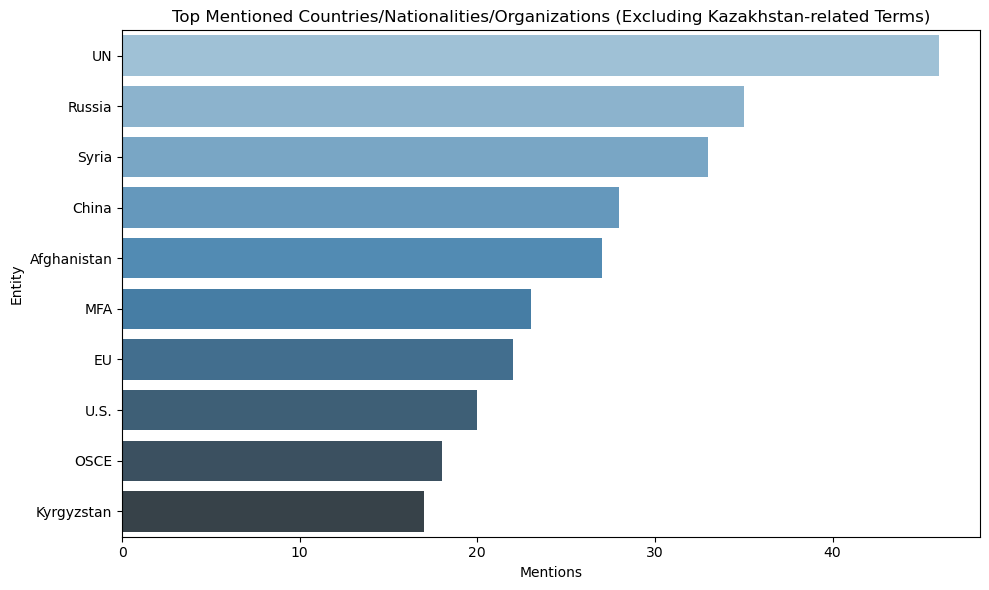

In [42]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize counters
country_mentions = Counter()
org_mentions = Counter()

# Define terms to ignore (case-insensitive)
EXCLUDED_TERMS = {
    "kazakh", "kazakhstan", "astana",
    "the republic of kazakhstan",
    "the ministry of foreign affairs", "kazakhstan presented credentials", "the ministry of foreign affairs of", "almaty", "the kazakh foreign ministry", "kazakh foreign ministry"
}

# Map nationalities to country names
nationality_to_country = {
    "Kazakh": "Kazakhstan",
    "American": "United States",
    "Russian": "Russia",
    "Chinese": "China",
    "British": "United Kingdom",
    "Moldovan": "Moldova",
    "Belarusian": "Belarus",
    "Paris" : "France"
}

# Process each row
for _, row in df.iterrows():
    title = row['title']
    if not isinstance(title, str):
        continue  # Skip rows where title is NaN or not a string
    doc = nlp(title)
    for ent in doc.ents:
        ent_text = ent.text.strip()
        ent_lower = ent_text.lower()

        # Skip excluded terms
        if ent_lower in EXCLUDED_TERMS:
            continue

        if ent.label_ == "GPE":
            country_mentions[ent_text] += 1
        elif ent.label_ == "NORP":
            mapped = nationality_to_country.get(ent_text, ent_text)
            if mapped.lower() not in EXCLUDED_TERMS:
                country_mentions[mapped] += 1
        elif ent.label_ == "ORG":
            if ent_lower not in EXCLUDED_TERMS:
                org_mentions[ent_text] += 1

# Combine and prepare for plotting
top_countries = pd.DataFrame(country_mentions.items(), columns=["Entity", "Count"])
top_orgs = pd.DataFrame(org_mentions.items(), columns=["Entity", "Count"])

top_combined = pd.concat([top_countries, top_orgs])
top_combined = top_combined.groupby("Entity", as_index=False).sum()
top_combined = top_combined.sort_values("Count", ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=top_combined, x="Count", y="Entity", palette="Blues_d")
plt.title("Top Mentioned Countries/Nationalities/Organizations (Excluding Kazakhstan-related Terms)")
plt.xlabel("Mentions")
plt.ylabel("Entity")
plt.tight_layout()
plt.show()


Between 2017 and 2025, the headlines published by the Kazakh Embassy most frequently referenced a set of key countries and regions, reflecting the focus of Kazakhstan’s diplomatic engagements. The top mentions include the UN (48), Russia (35), Syria (33), China (28), Afghanistan (27), the EU (22), and the United States (20). These patterns highlight both Kazakhstan’s immediate regional priorities and its broader international partnerships. These countries aren’t surprising, as they confirm what was already known, that Russia and China are major players in the region and that multilateral organizations such as the UN and EU remain central to Kazakhstan’s foreign policy. Now, the key question is whether the relationship between Kazakhstan and Russia has shifted since Russia’s invasion of Ukraine, as global sanctions isolate Moscow and create incentives for it to strengthen its alliances, including potentially deepening ties with Kazakhstan.

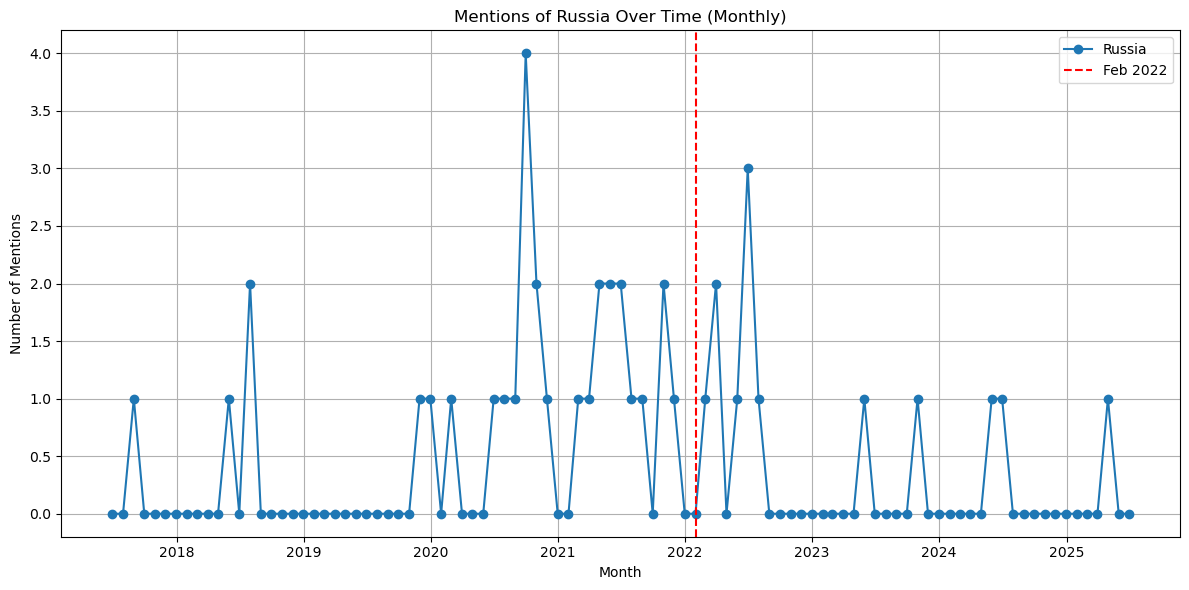

In [43]:
# Resample to monthly totals
monthly_mentions_df = mentions_df.resample('M').sum()

# Make sure "Russia" exists as a column
if "Russia" in mentions_df.columns:
    monthly_russia_mentions = mentions_df["Russia"].resample('M').sum()
else:
    raise ValueError("No mentions of 'Russia' found in data.")

plt.figure(figsize=(12, 6))
plt.plot(monthly_russia_mentions.index, monthly_russia_mentions, marker='o', label="Russia")

# Add vertical line at Feb 2022
plt.axvline(pd.to_datetime("2022-02-01"), color='red', linestyle='--', label="Feb 2022")

plt.title("Mentions of Russia Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of Mentions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In the period surrounding Russia’s invasion of Ukraine in February 2022, headlines from the Kazakh Embassy show that Russia was already one of the most frequently mentioned countries in Kazakhstan’s diplomatic reporting. While Russia continues to appear prominently in the embassy’s communications both before and after the invasion, there is no observable increase in mentions following the outbreak of the war. This suggests that, despite Russia’s growing isolation on the global stage, its relationship with Kazakhstan has neither intensified nor collapsed. This dynamic makes sense: Kazakhstan depends on Russia as a powerful neighbor and key partner, making it unlikely to fully align itself with the West against Moscow. At the same time, Kazakhstan is eager to attract investment from the broader international community and remains wary that Russia could one day turn its attention toward them, which discourages fully embracing Moscow either. Looking forward, as more countries distance themselves from Russia, it will be important to see whether they begin treating Kazakhstan as a more significant partner or allow relations to continue along their traditional path.

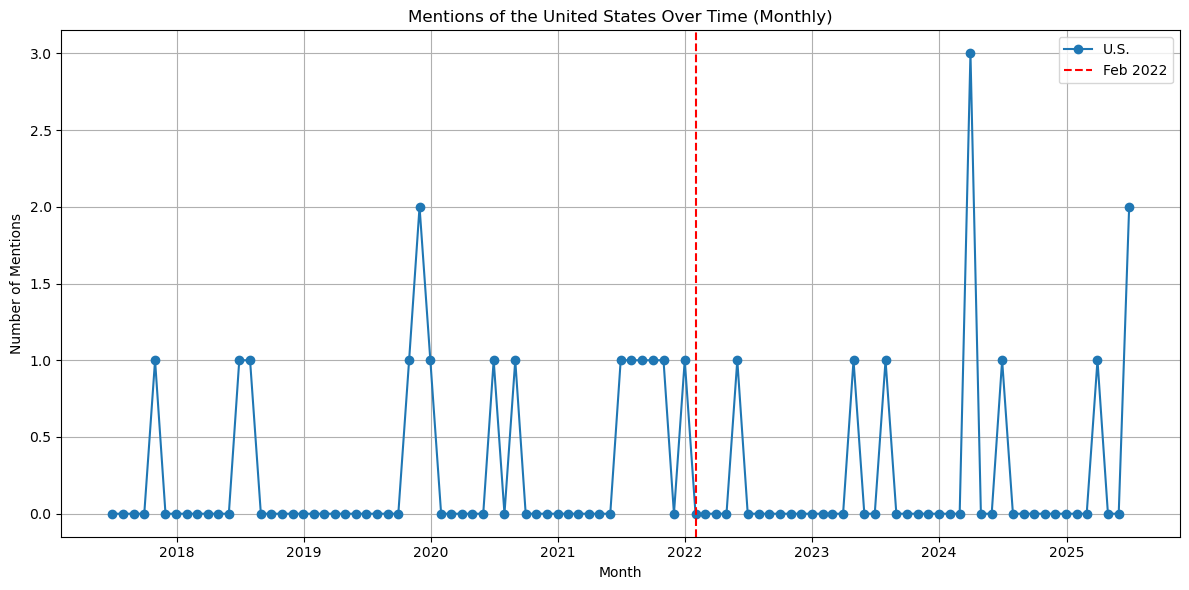

In [44]:
# Resample to monthly totals
monthly_mentions_df = mentions_df.resample('M').sum()

# Collect possible U.S. name variants
us_variants = ["US", "USA", "United States", "United States of America"]

# Check which variants are in the DataFrame
present_variants = [col for col in us_variants if col in mentions_df.columns]

if not present_variants:
    raise ValueError("No mentions of U.S. variants found in data.")

# Combine them into a single series
monthly_us_mentions = mentions_df[present_variants].resample('M').sum().sum(axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_us_mentions.index, monthly_us_mentions, marker='o', label="U.S.")

# Add vertical line at Feb 2022
plt.axvline(pd.to_datetime("2022-02-01"), color='red', linestyle='--', label="Feb 2022")

plt.title("Mentions of the United States Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of Mentions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Mentions of the United States in Kazakh Embassy headlines remain consistently infrequent both before and after Russia’s invasion of Ukraine, signaling steady engagement but not necessarily intensified cooperation. Given that Kazakhstan is not a strategically critical partner for the U.S., this pattern suggests that Washington’s current level of attention is sufficient to maintain visibility and influence without requiring major resource commitments. Kazakhstan’s oil and trade ties have helped Russia circumvent some sanctions and it could appear that closer U.S. engagement could contribute to strengthening enforcement. However, due to Kazakhstan’s limited strategic importance and its geographic and economic dependence on Russia, it is unlikely to ever fully align itself with the West. A prudent course of action for the U.S. would be to continue monitoring developments, sustain diplomatic and economic engagement at a measured level, and selectively collaborate on areas of mutual interest—such as regional security, trade, or energy rather than treating Kazakhstan as a high-priority strategic focus.